# Spectral analysis of local field potentials
Uses pywavelets (`import pywt`) to perform wavelet analysis of time series data. Plots the results as a spectrogram.

Check out the [pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/index.html) to learn more!

To learn the basics of conventional spectral analysis, you can check out one of my [lectures](https://github.com/dbheadley/DecodingTheBrain/blob/main/Week6/notes.ipynb).

For a more advanced and comprehensive discussion of spectral analysis, this [online textbook](https://brianmcfee.net/dstbook-site/content/intro.html) is exceptionally helpful and well illustrated.

In [ ]:
import os
import pywt
import dclut as dcl
import numpy as np
import xarray as xr
import scipy.signal as ss
import matplotlib.pyplot as plt
from mimo_pack.plot.map import wave_map, amp_map_xr
from mimo_pack.analysis.spectral import stft_xarray, fit_spectrum_aperiodic, fit_spectrum_aperiodic_xarray

In [2]:
# path to LFP dclut file goes here
lfp_path = os.path.join('D:', 'SortingTemp', '24-05-31_DH23_A1-IC_g0', 
                         '24-05-31_DH23_A1-IC_g0_imec0', 
                         '24-05-31_DH23_A1-IC_g0_t0.imec0.lfp_dclut.json')

## Setting up dclut file and deciding what LFP data to laod
Loading all recorded LFP data from a single session is often impractical due to the data size. This because especially problematic if you want to save wavelet spectrograms for all that data, since each data point is now stored as a complex number (which usually has twice the bytes) and for every frequency. However, since the LFP is often similar between adjacent electrodes, one can instead load a subset of the channels that are spaced far enough apart that they will tend to be less correlated. In most cases, a spacing of ~100 microns along both the x and y directions is satisfactory.

Let's start by setting up our dclut object for the LFP data and visualizing the locations of the electrodes.

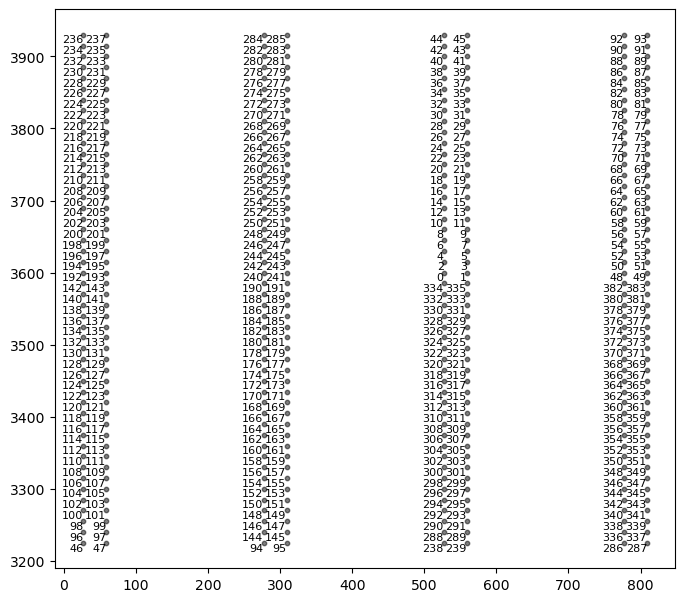

In [3]:
lfp_dcl = dcl.dclut(lfp_path)

# get the electrode positions
x_pos = lfp_dcl.scale_values('ch_x')
y_pos = lfp_dcl.scale_values('ch_y')

fig, ax = plt.subplots(figsize=(8, 8))
# plot the electrode positions
ax.scatter(x_pos, y_pos, s=10, c='k', alpha=0.5)
ax.set_aspect('equal')
# plot the electrode numbers
for i, (x, y) in enumerate(zip(x_pos, y_pos)):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='top')

We will now create a grid of points that tile the area encompassed by the electrodes. We will start the grid with the 'lower left' point, and tile it across the entire area spanned by the electrodes. When setting the grid spacing, keep the arrangement of the electrodes in mind. For this example, 100 microns will work along the y-axis, but along the x-axis the spacing should be 250 microns.

Note: we use the 'nan' version of numpy functions because the sync pulse channel has NaNs for is positions since it does not have a physical location on the probe.

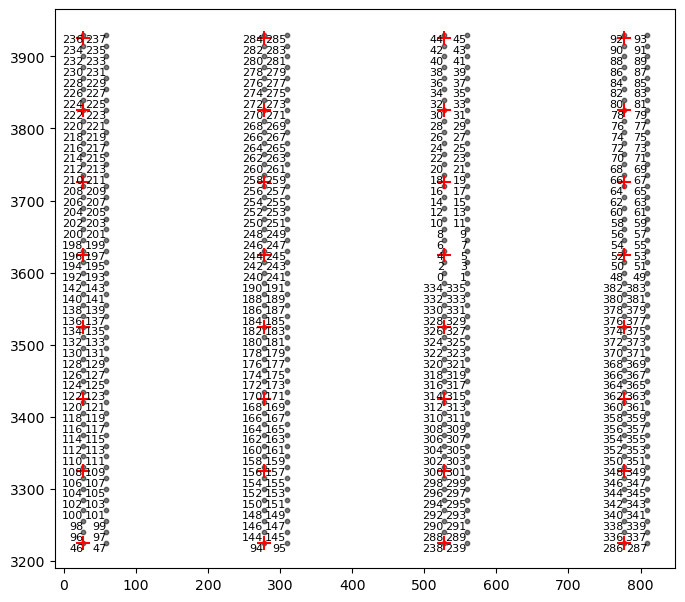

In [4]:
# set our spacing
x_space = 250
y_space = 100

# combine the x and y positions into a 2 column single array, then sort with the first columns and then the second
x_min = np.nanmin(x_pos)
y_min = np.nanmin(y_pos)
x_max = np.nanmax(x_pos)
y_max = np.nanmax(y_pos)

# create a grid of points
x_grid = np.arange(x_min, x_max, x_space)
y_grid = np.arange(y_min, y_max, y_space)

# create a meshgrid
X, Y = np.meshgrid(x_grid, y_grid)

fig, ax = plt.subplots(figsize=(8, 8))
# plot the electrode positions
ax.scatter(x_pos, y_pos, s=10, c='k', alpha=0.5)
ax.set_aspect('equal')
# plot the electrode numbers
for i, (x, y) in enumerate(zip(x_pos, y_pos)):
    ax.text(x, y, str(i), fontsize=8, ha='right', va='top')

# plot the grid points
ax.scatter(X, Y, s=100, c='r', marker='+')

Now we just need to pass those coordinates to our LFP dclut object when selecting the electrodes we want to record from. It will automatically identify those electrodes whose x an y coordinates are closest.

In [5]:
t = lfp_dcl.scale_values('time')

# find last value of t that is not a nan
t_max = t[np.where(~np.isnan(t))[0][-1]-1]

lfp_dcl.reset()
lfp_dcl.points(select={'ch_x': X.flatten(), 'ch_y': Y.flatten()})
lfp_dcl.intervals(select={'time': [[0, t_max]]})
lfp = lfp_dcl.read(format='xarray')[0]

Note that we excluded the end of the recording where the time points were labeled with NaNs. This is because when we want to select time slices from the LFP x-array object (`lfp`), we need all time points to be monotonically increasing.

With the data loaded, let' inspect it. We will plot a short segment of the LFP signal from each electrode, positioned where the electrode is. To do this, we will use the `wave_map` function in mimopack.

<Axes: >

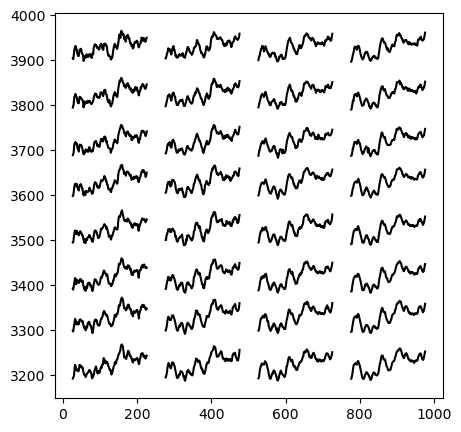

In [6]:
# get the ch_x values from the xarray lfp
ch_x = lfp.ch_x.values
ch_y = lfp.ch_y.values

# select a time segment of the LFP data
t = lfp.time.values
t_start = 300.0
t_end = 300.2
sig = lfp.sel(time=slice(t_start, t_end)).values #

# remove the mean voltage from each channel, to avoid DC offset
sig = sig - np.mean(sig, axis=0, keepdims=True)

# plot the LFP data
fig, ax = plt.subplots(figsize=(5, 5))
wave_map(sig, ch_x, ch_y, ax=ax, y_scale=0.5)

## Spectral analysis with short-time fourier transform
With our data now loaded, we can perform spectral analysis. To start, we will calculate the power spectrum of the LFP on each electrode. To do this, we will use the short-time Fourier transform. It applies a fourier transform to short windows of data (typically 1 second), stepping across the entire recording duration. There are a few advantages to this approach. First, it can give a high frequency resolution. For instance, a 1 second window will yield a frequency resolution of 1 Hz (1/1sec). The maximum frequency it can measure is half the sample rate. Typically we have a 1kHz sample rate for LFPs, so the maximum frequency will be 500 Hz. Second, since a spectrum is only calculated for each window, it will not take up too much memory. Third, since the power spectrum is calculated for a series of windows spanning our recording, we can visually inspect changes in it across the entire session. This is especially useful if we want to identify diffrent behavioral states, such as sleeping versus active waking.

To calculate the short-time Fourier transform, we will use the convenience function `stft_xarray` found in mimopack. It allows you to directly pass an x-array object to the `ShortTimeFFT` class in Scipy. It returns another x-array object, which is the short-time Fourier transform across all recorde channels. The spectral data is a 3D array with axes [time, channel, frequency].

In [7]:
# Apply STFT to the signal
lfp_s = stft_xarray(lfp, window=1.0)

Let's now inspect result for a single channel.

Text(0.5, 1.0, 'STFT of LFP signal')

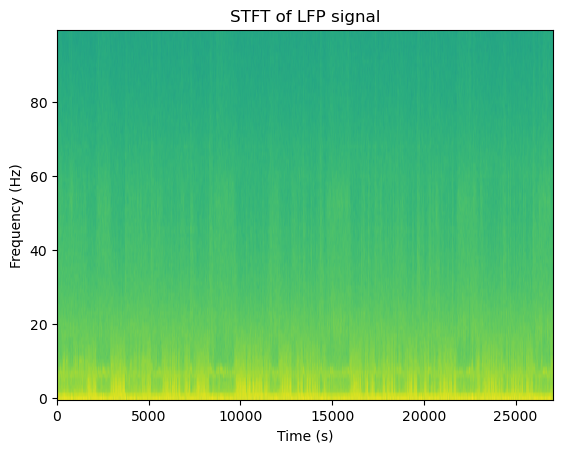

In [8]:
fig, ax = plt.subplots()
ax.imshow(np.log(lfp_s.data[:,0,:100]).T, aspect='auto',vmax=20)
ax.invert_yaxis()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('STFT of LFP signal')

Notice that it is difficult to see any changes in the spectrum across time. This is because the power spectrum is dominated by a *1/f* or *aperiodic* component. This corresponds to a linear decrease in power with frequency when the spectrum is plotted on a log-log plot. We can see this clearly if we look at the mean power spectrum on this channel across the entire recording session.

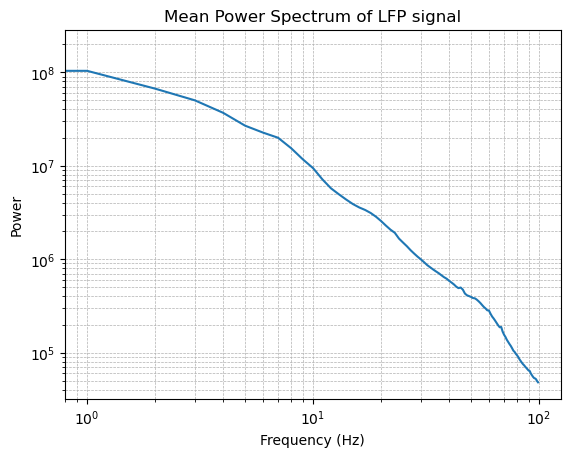

In [9]:
mean_spec = np.mean(lfp_s.data[:,1,:], axis=0)[:100]
freqs = lfp_s.frequency.values[:100]
fig, ax = plt.subplots()
ax.plot(freqs, mean_spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Mean Power Spectrum of LFP signal')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

We can account for the aperiodic component by fitting a curve to it. In mimopack there is a function just for this, `fit_spectrum_aperiodic`. Once the aperiodic component is fitted, you can calculate the relative change in spectral power from the aperiodic component.

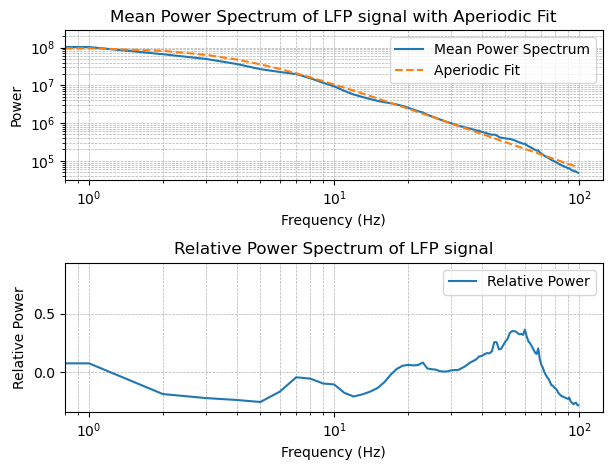

In [10]:
mean_spec_ap, _ = fit_spectrum_aperiodic(freqs, mean_spec)

fig, ax = plt.subplots(2,1)
ax[0].plot(freqs, mean_spec, label='Mean Power Spectrum')
ax[0].plot(freqs, mean_spec_ap, label='Aperiodic Fit', linestyle='--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_title('Mean Power Spectrum of LFP signal with Aperiodic Fit')
ax[0].legend()
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

ax[1].plot(freqs, (mean_spec - mean_spec_ap) / mean_spec_ap, label='Relative Power')
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Relative Power')
ax[1].set_title('Relative Power Spectrum of LFP signal')
ax[1].legend()
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

The curve of relative power exhibits several 'bumps'. Their peak frequencies are ones that correspond to known rhythmic components in the LFP signal. In particular, you can see bumps around 7 Hz (theta), 20 Hz (beta), and 52 Hz (gamma). You should also note several sharp, but small, peaks. One of these is at 60 Hz and likely corresponds to the 60 Hz power line artifact. The others are at multiples of ~22 Hz, and may reflect some other source of electrical noise that is not power line related. Thankfully, the amplitude of these is relatively minor, so we will ignore them.

Seeing how removal of the aperiodic component brings out rhythmic features in the power spectrum, we can apply the same calculation to every time window in our short-time Fourier transformed spectrogram.

In [16]:
lfp_s_ap = fit_spectrum_aperiodic_xarray(lfp_s, f_range=[0, 100], suppress_error=True)

c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:159: RuntimeWarning: invalid value encountered in log10
  return offset - np.log10(knee + x**exp)
c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:159: RuntimeWarning: divide by zero encountered in power
  return offset - np.log10(knee + x**exp)
c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:192: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_knee, xp, yp, **kwargs)


Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Opti

In [26]:
lfp_s

<xarray.DataArray (time: 27040, channel: 32, frequency: 500)> Size: 3GB
array([[[5.22471891e+09, 3.33792403e+09, 9.98099009e+08, ...,
         1.94276317e+04, 2.30193593e+04, 2.32414479e+04],
        [4.65564624e+09, 2.97045889e+09, 8.76815107e+08, ...,
         1.85024918e+04, 2.42223527e+04, 2.70678707e+04],
        [4.08318953e+09, 2.60975882e+09, 7.70916002e+08, ...,
         2.35312880e+04, 2.89208504e+04, 3.53221368e+04],
        ...,
        [5.10347469e+09, 3.28312182e+09, 1.02578349e+09, ...,
         2.52759656e+04, 2.79000582e+04, 2.80054056e+04],
        [5.65045979e+09, 3.61560014e+09, 1.11294699e+09, ...,
         2.43644033e+04, 2.79509157e+04, 2.84242430e+04],
        [5.71967055e+09, 3.65410879e+09, 1.11842792e+09, ...,
         2.71475371e+04, 3.08115284e+04, 2.84658978e+04]],

       [[1.05986491e+10, 2.58363550e+09, 7.16053825e+07, ...,
         3.27793799e+02, 9.71450677e+02, 1.24974346e+03],
        [8.46341534e+09, 2.07386086e+09, 6.35952913e+07, ...,
         4.53574151e+02, 2.66046959e+02, 3.24442259e+02],
        [7.40842114e+09, 1.81424749e+09, 5.72034753e+07, ...,
         4.36750768e+02, 1.47946587e+03, 1.36448221e+03],
...
         1.69366516e+03, 7.12626300e+02, 2.80721997e+01],
        [3.63868506e+08, 2.37815836e+07, 6.73743409e+06, ...,
         4.23106722e+02, 1.95217687e+02, 1.34017865e+02],
        [2.53589923e+07, 4.76456557e+07, 1.14080609e+07, ...,
         5.09125271e+01, 7.67810405e+02, 1.36366442e+03]],

       [[2.21629063e+06, 1.99125507e+06, 1.42833961e+06, ...,
         1.09827196e+01, 1.32462674e+00, 9.24917817e+00],
        [1.96805631e+02, 5.75118723e+04, 1.79546531e+05, ...,
         2.72188675e+00, 6.96027308e-01, 6.71069252e-02],
        [1.30258616e+05, 1.54516924e+05, 1.99970008e+05, ...,
         9.06144106e+00, 9.55874219e+00, 9.05225471e+00],
        ...,
        [1.50552379e+06, 1.35220366e+06, 9.67908172e+05, ...,
         3.63663280e+01, 7.99586045e+01, 1.31000991e+02],
        [7.23949493e+06, 6.44115647e+06, 4.47924552e+06, ...,
         5.93285955e+01, 1.29549008e+02, 2.35022325e+02],
        [1.30876702e+06, 1.18293764e+06, 8.64125643e+05, ...,
         1.15644633e+01, 1.81352426e+01, 3.79392253e+01]]],
      shape=(27040, 32, 500))
Coordinates:
  * channel    (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
    ch_name    (channel) <U9 1kB 'AP4;4' 'AP16;16' ... 'AP360;360' 'AP374;374'
    ch_order   (channel) int64 256B 246 258 272 286 0 ... 218 232 302 314 328
    ch_x       (channel) float64 256B 527.0 527.0 527.0 ... 777.0 777.0 777.0
    ch_y       (channel) float64 256B 3.63e+03 3.72e+03 ... 3.42e+03 3.525e+03
    ch_shank   (channel) float64 256B 2.0 2.0 2.0 2.0 0.0 ... 2.0 3.0 3.0 3.0
    s1         (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
  * frequency  (frequency) float64 4kB 0.0 1.001 2.002 ... 497.5 498.5 499.5
  * time       (time) float64 216kB 0.0 0.999 1.998 ... 2.701e+04 2.701e+04
    s0         (time) int64 216kB 0 1 2 3 4 5 ... 27035 27036 27037 27038 27039

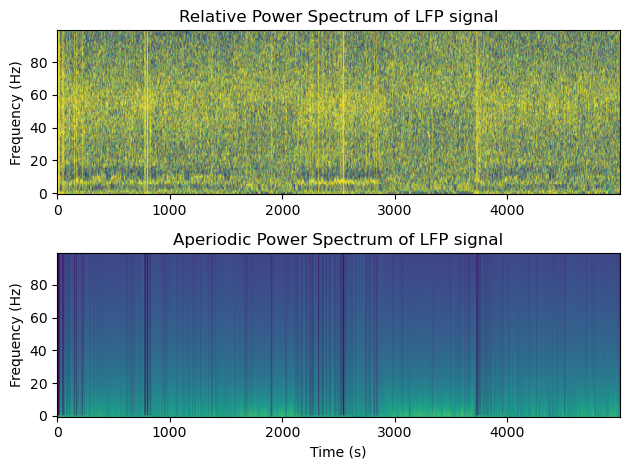

In [30]:
rel_spec = (lfp_s.sel(channel=16) - lfp_s_ap.sel(channel=16)) / lfp_s_ap.sel(channel=16)
fig, ax = plt.subplots(2,1)
ax[0].imshow(rel_spec[:5000, :100].T, aspect='auto', vmax = 1, vmin=-1)
ax[0].invert_yaxis()
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Relative Power Spectrum of LFP signal')

ax[1].imshow(np.log(lfp_s_ap.data[:5000,1,:100].T), aspect='auto', vmax=25)
ax[1].invert_yaxis()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('Aperiodic Power Spectrum of LFP signal')
plt.tight_layout()

We can now clearly see that there are two kinds of activity. Focusing on the graph of relative power (proportional change from 1/f), some periods exhibit elevated power in the theta, beta, and gamma bands. This likely corresponds to active waking. The other shows some broadband power increases around 60 Hz, but nothing else. Examining the aperiodic power spectrogram graph, those epochs show elevated low frequency power. This likely reflects quiet waking or sleeping.

So far we have focused on the power spectrum from a single electrode, and found that it changes across time. During active periods it shows a prominent gamma bump. But does this gamma vary across electrodes? To examine that, we will get the mean power spectrum for each channel, measure deviation from the aperiodic component, and then plot the strength of the gamma bump for each site.

In [31]:
# mean spectrum across time for each channel
# note that xarrays support many operations like numpy, returning
# a new xarray with the same dimensions as the original, but with the
# specified dimension reduced to a single value
mean_spec_ch = lfp_s.mean(dim='time')

# calculate the aperiodic fit for the mean spectrum
mean_spec_ch_ap = fit_spectrum_aperiodic_xarray(mean_spec_ch, f_range=[0, 100])

# get the relative power spectrum for each channel
rel_spec_ch = (mean_spec_ch - mean_spec_ch_ap) / mean_spec_ch_ap

rel_spec_ch

c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:159: RuntimeWarning: invalid value encountered in log10
  return offset - np.log10(knee + x**exp)
c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:159: RuntimeWarning: divide by zero encountered in power
  return offset - np.log10(knee + x**exp)


<xarray.DataArray (channel: 32, frequency: 500)> Size: 128kB
array([[ 1.5363978 ,  0.0101493 , -0.4220248 , ..., -0.34173815,
        -0.33921727, -0.33056564],
       [ 0.87561703,  0.07476755, -0.18753333, ..., -0.06287577,
        -0.06348536, -0.05731375],
       [ 0.65107951,  0.05083754, -0.13825477, ..., -0.09464491,
        -0.10222718, -0.10380135],
       ...,
       [ 2.70728245,  0.54361435, -0.24395709, ..., -0.12288734,
        -0.12603181, -0.11022804],
       [ 2.6446614 ,  0.10490871, -0.74104703, ..., -0.46724265,
        -0.45891837, -0.45008036],
       [ 2.28169575,  0.46353025, -0.2241748 , ..., -0.02336576,
        -0.02226265, -0.00490437]], shape=(32, 500))
Coordinates:
  * channel    (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
    ch_name    (channel) <U9 1kB 'AP4;4' 'AP16;16' ... 'AP360;360' 'AP374;374'
    ch_order   (channel) int64 256B 246 258 272 286 0 ... 218 232 302 314 328
    ch_x       (channel) float64 256B 527.0 527.0 527.0 ... 777.0 777.0 777.0
    ch_y       (channel) float64 256B 3.63e+03 3.72e+03 ... 3.42e+03 3.525e+03
    ch_shank   (channel) float64 256B 2.0 2.0 2.0 2.0 0.0 ... 2.0 3.0 3.0 3.0
    s1         (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
  * frequency  (frequency) float64 4kB 0.0 1.001 2.002 ... 497.5 498.5 499.5

In [13]:
mean_spec_ch_ap

<xarray.DataArray (channel: 32, frequency: 500)> Size: 128kB
array([[1.57008867e+08, 1.44460541e+08, 1.11954388e+08, ...,
        1.96292468e+03, 1.95421678e+03, 1.94556486e+03],
       [1.00971385e+08, 9.63410720e+07, 8.21614527e+07, ...,
        1.77906114e+03, 1.77102631e+03, 1.76304378e+03],
       [9.73643994e+07, 9.28422614e+07, 7.91353814e+07, ...,
        1.80547351e+03, 1.79735692e+03, 1.78929298e+03],
       ...,
       [6.18993913e+07, 6.11002495e+07, 5.76316484e+07, ...,
        8.52693020e+02, 8.48416775e+02, 8.44170489e+02],
       [3.13055886e+08, 2.67209015e+08, 1.71347208e+08, ...,
        1.38968344e+03, 1.38335960e+03, 1.37707714e+03],
       [5.93209232e+07, 5.84871015e+07, 5.49513473e+07, ...,
        8.57390730e+02, 8.53128004e+02, 8.48894958e+02]], shape=(32, 500))
Coordinates:
  * channel    (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
    ch_name    (channel) <U9 1kB 'AP4;4' 'AP16;16' ... 'AP360;360' 'AP374;374'
    ch_order   (channel) int64 256B 246 258 272 286 0 ... 218 232 302 314 328
    ch_x       (channel) float64 256B 527.0 527.0 527.0 ... 777.0 777.0 777.0
    ch_y       (channel) float64 256B 3.63e+03 3.72e+03 ... 3.42e+03 3.525e+03
    ch_shank   (channel) float64 256B 2.0 2.0 2.0 2.0 0.0 ... 2.0 3.0 3.0 3.0
    s1         (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
  * frequency  (frequency) float64 4kB 0.0 1.001 2.002 ... 497.5 498.5 499.5

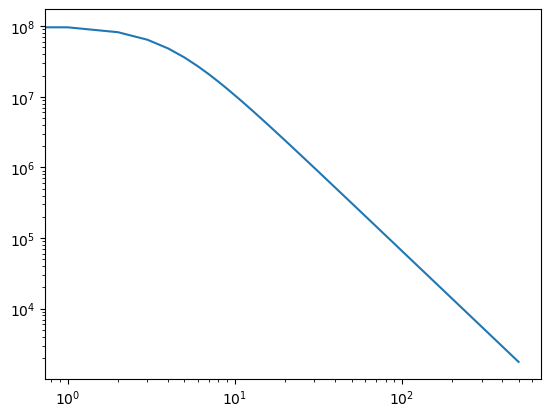

In [15]:
plt.plot(mean_spec_ch_ap.frequency.values, mean_spec_ch_ap.data[1,:].T, label='Aperiodic Fit')
plt.xscale('log')
plt.yscale('log')